<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Machine Learning Using Python (MEAFA Workshop)</h1></center>
<center><h2>Lesson 1: Introduction to Machine Learning</h2></center>
<br>

In this tutorial we will use the linear regression and K-nearest neigbours regression methods to illustrate key steps of a  machine learning project: splitting a dataset into training and test sets, estimating, tuning and selecting models, making predictions,and evaluating generalisation performance. We will also illustrate oither important practical aspects of modelling, such as using exploratory data analysis.


<a href="#Credit-Card-Data">Credit Card Data</a> <br>
<a href="#Training-and-Test-Sets">Training and Test Sets</a> <br>
<a href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#Data-Preparation">Data Preparation</a> <br>
<a href="#Linear-Regression">Linear Regression</a> <br>
<a href="#K-Nearest-Neighbours-Regression">K-Nearest Neighbours Regression</a> <br>
<a href="#Model-Tuning-and-Selection-with-Cross-Validation">Model Tuning and Selection</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>


This notebook relies on the following imports and setting. We will load new functions and libraries in context to make clear what we are using them for. 

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # this is to clear the warnings from this page, usually we should leave them on

In [2]:
# Plot settings
sns.set_context('notebook') # optimise figures for notebook display
sns.set_style('ticks') # set default plot style
palette1 = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
palette2 = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(palette1) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

##Credit Card Data

In this lesson we will use the <TT>Credit</TT> dataset taken from the  <a href="http://www-bcf.usc.edu/~gareth/ISL/index.html" target="_blank">Introduction to Statistical Learning</a> texbook by James, Witten, Hastie and Tibshirani. The dataset records the average credit card balace at end of the month for customers of a financial services company, as well as other individual characteristics such age, education, gender, marital status, number of cards, and credit rating.

**Business objective**: To predict the average monthly credit card balance of customers based on individual characteristics.  

We start by loading the data. First, we need to load the pandas package. Since the dataset is in the <TT>csv</TT> format, we use the <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html" target="_blank"><TT>read_csv</TT></a> function to import the file. The package will automatically read the column names and infer the variable types.  We assign the data variable to a variable called *data*, which will store the dataset as an object called a <TT>DataFrame</TT>.

In [3]:
# We will always assume that the data file is in a subdirectory called "Datasets"

data=pd.read_csv('Datasets/Credit.csv', index_col='Obs')
data.head(10)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
Obs,,,,,,,,,,,
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
6,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151
7,20.996,3388,259,2,37,12,Female,No,No,African American,203
8,71.408,7114,512,2,87,9,Male,No,No,Asian,872
9,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279


##Training and Test Sets

We use the Scikit-Learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html" target="_blank"><TT>train_test_split</TT></a> method to split the data into training and test sets. 

Below, we specify that the training set will contain 70% of the data. The random state parameter is an arbitrary number. Specifiying means that by setting this random state, we willget the same training and test sets if we run the analysis again, even though the split is random. 

In [4]:
from sklearn.model_selection import train_test_split

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.7, random_state=10)

# Write training and test sets 
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

##Exploratory data analysis

Exploratory data analysis (EDA) is the process of discovering features and patterns in the data that should inform the modelling process and in some cases prevent errors. Here, we conduct a short EDA of the dataset. Remember that we should use only the training set for this purpose. 

We start by computing the descriptive statistics and pairwise correlations for the numerical variables (we will discuss categorial predictors next week). When displaying the results, we chain a command to round the results to two decimal place to facilitate visual inspection.

The count row in the first table shows the number available observations for each variable. In this case all variables have the same count, reassuring us that there are no missing values.  The response has a large standard deviation (470) relative to the mean (504): we should keep the magnitudes in mind when discussing coefficient sizes and prediction errors.  The first quartile of the response is zero, indicating that substantial fraction of the credit card customers have zero or low balance. 

In [5]:
print(len(train)) #  number of observations in the training data frame
train.describe().round(1) # rounding the table to one decimal digit

280


,Income,Limit,Rating,Cards,Age,Education,Balance
count,280.0,280.0,280.0,280.0,280.0,280.0,280.0
mean,44.6,4731.4,354.5,2.9,55.3,13.4,521.1
std,34.8,2343.7,156.6,1.3,17.3,3.2,458.2
min,10.4,855.0,93.0,1.0,23.0,5.0,0.0
25%,19.7,3082.5,247.2,2.0,41.0,11.0,64.0
50%,33.0,4636.0,344.0,3.0,54.0,14.0,459.5
75%,57.5,6034.8,443.5,4.0,69.0,16.0,864.2
max,186.6,13913.0,982.0,9.0,98.0,20.0,1999.0


The pairwise correlations reveal that the predictors that are most correlated with the response are limit, rating, and income. The remaining predictors have very low correlation with credit card balances. Another important finding is that limit and rating have nearly perfect positive correlation and are therefore redudant predictors (using both in regression analysis would lead to collinearity problems). Also note that income is highly correlated with limit and rating. Limit seems to be the key linear predictor in data. 

In [6]:
train.corr().round(2)

,Income,Limit,Rating,Cards,Age,Education,Balance
Income,1.00,0.80,0.80,-0.01,0.17,0.02,0.49
Limit,0.80,1.00,1.00,-0.01,0.10,0.00,0.87
Rating,0.80,1.00,1.00,0.03,0.10,-0.01,0.88
Cards,-0.01,-0.01,0.03,1.00,0.11,-0.11,0.04
Age,0.17,0.10,0.10,0.11,1.00,-0.05,0.02
Education,0.02,0.00,-0.01,-0.11,-0.05,1.00,0.01
Balance,0.49,0.87,0.88,0.04,0.02,0.01,1.00


We now investigate the (unconditional) distribution of the response by plotting a histogram. We find that the response has a pronouncedly right skewed distribution. A substantial number of customers has zero (as confirmed in the following cell) or low credit card balance. 

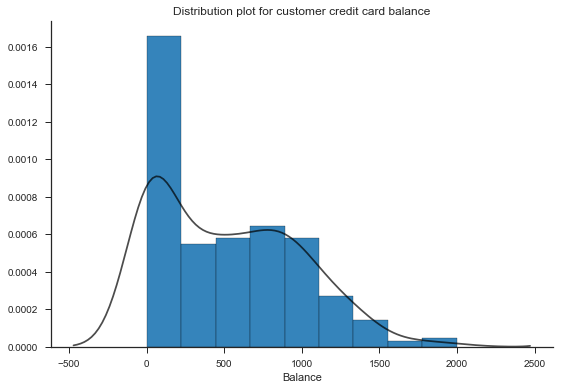

In [7]:
fig, ax = plt.subplots()
sns.distplot(train['Balance'], ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black'},
             kde_kws={'color': 'black', 'alpha': 0.7})
ax.set_title('Distribution plot for customer credit card balance')
sns.despine()
plt.show()

A scatter plot of credit limit with credit balance reveals that there is a nonlinear relatioship between these two variables. Furtheremore, there are several clients with a response value of zero, which is likely to affect model fit.

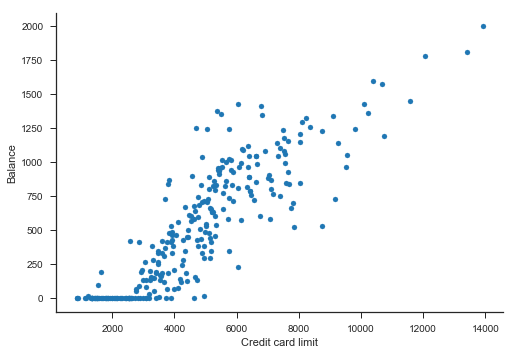

In [8]:
fig, ax = plt.subplots(figsize=(8,5.5))
plt.scatter(train['Limit'], train['Balance'], s=25) # the s option is the size of the dot
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Balance')
sns.despine()
plt.show()

The next cell illustrates how we can create a figure to explore the relationship between a discrete variables with not too many distinct values and the response. 

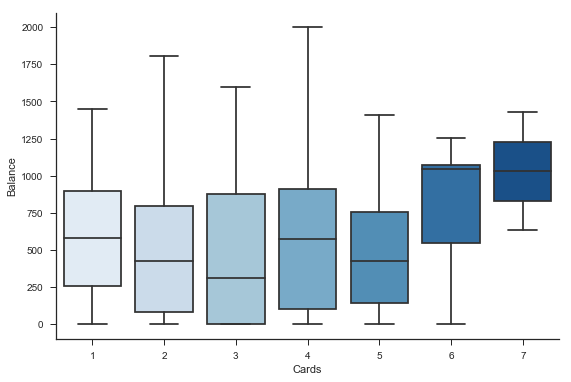

In [9]:
rows=train['Cards']<=7 # too few observations for more than 7 cards
sns.boxplot(x=train.loc[rows,'Cards'], y=train.loc[rows,'Balance'], palette='Blues')
sns.despine()
plt.show()

##Data Preparation

In most cases, we need to performance additional processing to get the data ready for training machine learning models and computing predictions. It is good practice to write a function for this step, for several reasons: 

* It allows you to easily reproduce the data processing steps.
* It helps you to build a library of data processing steps, which can save you a lot of time in the future. 
* You can use the function to continuously process new data in a live system.
* This makes it simple for you to try different data tranformations. 

In [10]:
def prepare_data(df):
    df['Male']=(df['Gender'] ==' Male').astype(int) # create dummy variable for gender
    df['Student']=(df['Student'] =='Yes').astype(int)
    df['Married']=(df['Married'] =='Yes').astype(int)
    df['Caucasian']=(df['Ethnicity'] =='Caucasian').astype(int)
    df['Asian']=(df['Ethnicity'] =='Asian').astype(int)
    df=df.loc[:, df.dtypes!='object'] # discards the columns that are not numerical
    return df

train = prepare_data(train)
test = prepare_data(test)

train.head()

,Income,Limit,Rating,Cards,Age,Education,Student,Married,Balance,Male,Caucasian,Asian
Obs,,,,,,,,,,,,
400,18.701,5524,415,5,64,7,0,0,966,0,0,1
26,14.090,4323,326,5,25,16,0,1,671,0,0,0
280,54.319,3063,248,3,59,8,1,0,269,0,1,0
261,67.937,5184,383,4,63,12,0,1,345,1,0,1
131,23.793,3821,281,4,56,12,1,1,868,0,0,0


Finally, we need to identify and separate the response and the predictors. For illustrative purposes, we use only one predictor in this lesson, the customer's credit card limit. 

In [11]:
# Construting response vector and design matrix (matrix of predictor values) 

response = 'Balance'
predictors = ['Limit',] # in general we will be working with a list of predictors, even though we only have one here

# If we wanted to use all available predictors: 
# predictors = [variable for variable in train.columns if variable!=response]

y_train = train.pop(response) # removes the response column for the train dataframe and copies it to a new variable
X_train=train[predictors].copy() # selects the variables in the predictor list

y_test = test.pop(response)
X_test=test[predictors].copy()

##Linear Regression

Scikit-Learn allows us to train and use a wide range of machine learning algorithms using a simple syntax structure: 

1. Import the method.
2. Specify the model and options.
3. Train the model.
4. Use the estimated model to make predictions. 

We start with a basic method, a linear regression. We use the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html" target="_blank"><TT>LinearRegression</TT></a> function from the to train the model. 

In [12]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Suppose that we want to predict the credit card balance of a customer that has a limit of 5000 dollars.

In [13]:
ols.predict(5000)

array([ 566.97270565])

Let's visualise the trained model. 

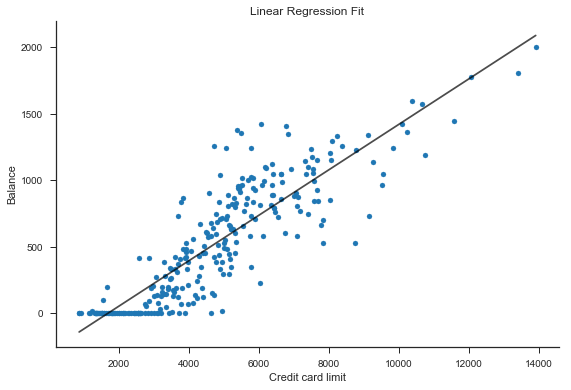

In [14]:
# Here, we generate a grid of 500 values ranging from the minimum to the maximum value of the variable in the training data
x = np.linspace(X_train.min(),X_train.max(), 2).reshape((-1,1))

# Compute the predicted values for each of these input points
y_pred = ols.predict(x)

# Figure
fig, ax = plt.subplots()
ax.scatter(X_train.values, y_train.values, s=25) # the s option is the size of the dot
ax.set_title("Linear Regression Fit")
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Balance')
ax.plot(x, y_pred, color='black', alpha = 0.7)
sns.despine()
plt.show()

##K-Nearest Neighbours

The previous figure suggests that the linear regression model may not be satisfactory for this data since the relationship between limit and balance appears to be nonlinear. The <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html" target="_blank"><TT>K-Nearest Neighbours</TT></a> (KNN) method is a flexible algorithm that can approximate complex relationships between the response and predictors without assuming a particular form for the regression function.
    
Using the KNN method with Scikit-Learn follows the template from above. Unlike in the linear regression model, however, we need to specify a hyper-parameter, the number of neighbours. 

In [15]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10) # we shoudl specify the number of neighbours
knn.fit(X_train, y_train)
knn.predict(5000)

array([ 566.2])

Let's visualise the relationship fitted by K-Nearest Neighbours algorithm using K=10 neighbours. 

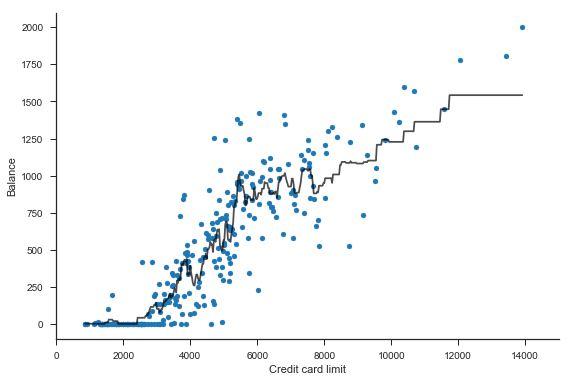

In [16]:
# Generate a grid of 500 values ranging from the minimum to the maximum value of the variable in the training data
x = np.linspace(train['Limit'].min(),train['Limit'].max(), 500).reshape((-1,1))

# Compute the predicted values for each of these input points
y_pred = knn.predict(x)

# Plot figure
fig, ax = plt.subplots()
ax.scatter(X_train.values, y_train.values, s=25) # the s option is the size of the dot
ax.set_xlabel('Credit card limit')
ax.set_ylabel('Balance')
ax.set_xlim(0, 15000)
ax.plot(x, y_pred, color='black', alpha = 0.7)
sns.despine()
plt.show()

The K-Nearest Neighbours fit depends strongly on the choice the number of neighbours. Choosing K=2 seems to overfit, while K=50 clearly underfits the training data. 

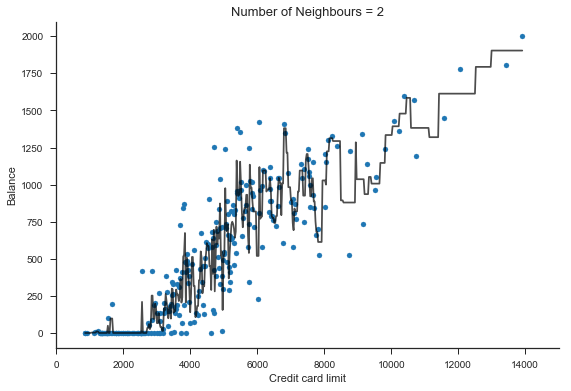

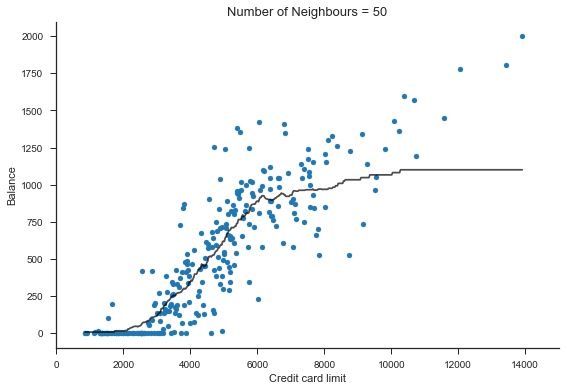

In [17]:
for K in [2, 50]:
    
    # Specify and fit model
    knn = KNeighborsRegressor(n_neighbors=K) 
    knn.fit(X_train, y_train)

    # Compute the predicted values for each point in the grid
    y_pred = knn.predict(x)

    # Plot figuer
    fig, ax = plt.subplots()
    ax.scatter(X_train.values, y_train.values, s=25) 
    ax.set_title(f'Number of Neighbours = {K}', fontsize=13)
    ax.set_xlabel('Credit card limit')
    ax.set_ylabel('Balance')
    ax.set_xlim(0, 15000)
    ax.plot(x, y_pred, color='black', alpha = 0.7)
    sns.despine()
    plt.show()

##Model Tuning and Selection

The previous sections leave us with two questions?

(a) How many neighbours should we use in the KNN method? 

(b) Should we use a linear regression or the KNN method as our final model?

We use [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) to estimate the generalisation performance of different model choices. For clarity, we refer to the choice a hyperparameter as tuning, and to the choice of method as model selection, even though both cases are referred to as model selection in statistics.

To select the number of neighbours, we need to specify a grid of candidate values and select the specification with best cross validation performance. The Scikit-Learn [<TT>GridSearchCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) method conveniently automates this process. We will follow the template below.

In [18]:
from sklearn.model_selection import GridSearchCV

model = KNeighborsRegressor() 
    
tuning_parameters = {
    'n_neighbors': np.arange(1,51),
}

knn =  GridSearchCV(model, tuning_parameters, cv=5,  scoring = 'neg_mean_squared_error', return_train_score=False, n_jobs=4)
knn.fit(X_train, y_train)

# Notes: 
# cv=5 specifies 5-fold cross-validation
# scoring = 'neg_mean_squared_error' specifies the evaluation criterion (redudant here, but useful as a template)
# return_train_score=False speeds up the computations by avoiding unnecessary calculations
# n_jobs=4 splits the task across four processor cores for greater speed

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=0)

We can access the <TT>best_params_</TT> attribute to view the selected value of the hyperparameter. 

In [19]:
knn.best_params_

{'n_neighbors': 7}

Performing a full grid search may become too computationally cost when we work with large datasets and/or methods that have multiple tuning hyperparameters. In this case, we can instead use the  [<TT>RandomizedSearchCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) function, which evaluates only a random subset of hyperparameter combinations. 

The syntax is very similar to the above, except that we will often want to specify the <TT>n_iter</TT> option in order to control the computational budget for the hyperparameter seach. Below, we specify that we would like to try twenty values for the number of neighbours. 

In [20]:
from sklearn.model_selection import RandomizedSearchCV

model = KNeighborsRegressor() 

tuning_parameters = {
    'n_neighbors': np.arange(1,101),
}

knn_rs =  RandomizedSearchCV(model, tuning_parameters, cv=5,  n_iter=20, scoring = 'neg_mean_squared_error',
                             return_train_score=False, n_jobs=4)
knn_rs.fit(X_train, y_train)
knn_rs.best_params_ # the result may not be the same as before because of the random search

{'n_neighbors': 7}

Now, suppose that we want to compute the cross validation score for a given model. The syntax is as follows. 

In [21]:
knn = KNeighborsRegressor(n_neighbors=7) 

from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
scores

array([-67849.01093294, -45920.26421283, -45435.79846939, -47949.19387755,
       -27784.71537901])

The [<TT>cross_val_score</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function returns the scores for each fold. Below, we average the scores and obtain the cross validation root mean squared error. 

In [22]:
np.sqrt(-1*np.mean(scores))

216.7666869570692

The scoring in Scikit-Learn follows the convention that higher score values are better than lower values. This is why the argument in the function is the negative mean squared error . The Scikit-Learn [model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html) documentation provides a list of scoring options. You should save this for future reference.

Often, the syntax is simplified by the fact that each method in Scikit-Learn has a default scoring method. In this case you have to consult the documentation to know what it is. For a [KNN regression the default scoring is the r-squared](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor).

We can do as follows to plot the cross validation error as a function of the hyperparameter. 

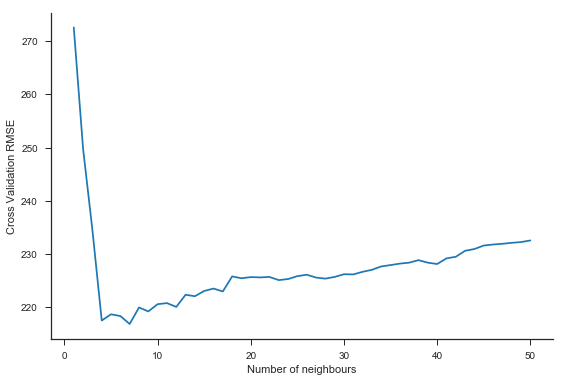

Lowest CV error: K = 7


In [23]:
neighbours=np.arange(1, 51)

cv_rmse = []
for k in neighbours: 
    model = KNeighborsRegressor(n_neighbors= k) 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(neighbours, cv_rmse)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Cross Validation RMSE')
sns.despine()
plt.show()
  
print(f'Lowest CV error: K = {1 + np.argmin(cv_rmse)}')   

We now turn to model selection. We use the [<TT>cross_val_predict</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) function and show the results for different evaluation metrics. We can also apply the [<TT>cross_val_score</TT>] function to build this type of table, but this is slower when considering multiple metrics. 

In [24]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

# Re-specifying the two models in context for clarity
ols = LinearRegression()
knn = KNeighborsRegressor(n_neighbors=7) 

# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['Linear Regression', 'KNN']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List of algorithms
methods = [ols, knn] 

# Computer cross-validation predictions and metrics
for i, method in enumerate(methods):
    y_pred = cross_val_predict(method, X_train, y_train, cv=5, n_jobs=4)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_train, y_pred))
    results.iloc[i, 1] = r2_score(y_train, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_train, y_pred) 

results.round(2)

,RMSE,R-Squared,MAE
Linear Regression,225.61,0.76,171.13
KNN,216.77,0.78,149.48


##Model evaluation

We now assess the performance of our selected model in the test data, also displaying the results for the linear regression for comparison. The results confirm that we made a good choice by selecting the KNN as the model to predict new data. 

In [25]:
# Training
ols.fit(X_train, y_train)
knn.fit(X_train, y_train)

# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['Linear Regression', 'KNN']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List algorithms
methods = [ols, knn] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(X_test)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_test, y_pred) 

results.round(2)

,RMSE,R-Squared,MAE
Linear Regression,254.82,0.70,197.13
KNN,242.78,0.73,170.94


##Practice

Build on the preceding analysis by considering more predictors. The following specification will work best for the KNN method in this dataset when there are multiple predictors, with the number of neighbours to be determinde.  

In [26]:
knn = KNeighborsRegressor(n_neighbors = k, metric='mahalanobis', metric_params={'V': X_train.cov()}) 